In [1]:
import stokespy
from stokespy import get_HMI_data, get_SP_data, StokesParamCube, StokesParamMap, StokesProfile
import datetime
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, SpectralCoord
from astropy.wcs.wcsapi import SlicedLowLevelWCS, HighLevelWCSWrapper

from sunpy.image import coalignment
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ndcube

from scipy import ndimage

matplotlib.use('TkAgg')

import warnings
warnings.filterwarnings('ignore')

# Setup the autoreload function.
%load_ext autoreload
%autoreload 2

In [3]:
def get_image_shift(image1, image2):
    # slightly modified code snippet from bitbucket to determine the shift
    # between two images using FFT:
    
    # discrete fast fourier transformation and complex conjugation of image2 
    image1FFT = np.fft.fft2(image1)
    image2FFT = np.conjugate( np.fft.fft2(image2) )

    # inverse fourier transformation of product -> equal to cross correlation
    imageCCor = np.real( np.fft.ifft2( (image1FFT*image2FFT) ) )

    # shift the zero-frequency component to the center of the spectrum
    imageCCorShift = np.fft.fftshift(imageCCor)

    # determine the distance of the maximum from the center
    row, col = image1.shape

    yshift, xshift = np.unravel_index( np.argmax(imageCCorShift), (row,col) )

    xshift -= int(col/2)
    yshift -= int(row/2)

    return xshift, yshift

# Load SDO/HMI data series

In [2]:
# Select a date and time to search for observations.
#user_date = astropy.time.Time(datetime.datetime(2016, 7, 28, 23, 57, 0), scale='tai')  # Original
#user_date = astropy.time.Time(datetime.datetime(2017, 8, 22, 17, 11, 4), scale='tai')  # AR near limb
user_date = astropy.time.Time(datetime.datetime(2017, 9, 5, 3, 4, 4), scale='tai')  # AR near disc center

# Find the nearest set of Stokes and corresponding inversion results.
#all_fnames_stokes, all_fnames_magvec = get_HMI_data(user_date, user_notify='gdima@hawaii.edu', download=False)
lvl1_data, lvl1_wcs, lvl2_data, lvl2_wcs = \
    get_HMI_data(user_date, user_notify='gdima@hawaii.edu', 
                 download=False, show_files=False, derotate=True)

Time window used for the search:  <sunpy.net.attrs.Time(2017-09-05 03:04:03.000, 2017-09-05 03:04:05.000)>
User directory pointing to SDO data is not included.
Setting the default directory to: /Users/gdima/Desktop/stokespy/stokespy_notebooks/Data/SDO/
No download requested. Found 24 Stokes files with unique timestamp(s):
['20170905_030000_TAI']
No download requested. Found 25 inversion files with timestamps: 
['20170905_030000_TAI']
OBS: Derotating each image
Created Stokes data cube with dimensions: (4, 6, 4098, 4098)
OBS: Derotating each magnetic field image.
Created magnetic field data cube with dimensions: (3, 4098, 4098)


In [3]:
# Create the HMI Cubes
lvl1_c_HMI = stokespy.StokesCube(lvl1_data, lvl1_wcs)
lvl2_c_HMI = stokespy.MagVectorCube(lvl2_data, lvl2_wcs)
print('HMI Stokes data shape: ', lvl1_c_HMI.data.shape)
print('HMI magnetic data shape: ', lvl2_c_HMI.data.shape)

HMI Stokes data shape:  (4, 6, 4098, 4098)
HMI magnetic data shape:  (3, 4098, 4098)


In [18]:
# Information from the WCS attached to the cubes.
# Note the index ordering is different between the data array and the header information.
# 
lvl1_c_HMI.wcs,lvl2_c_HMI.wcs

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.0  0.0  6.173345e-07  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  3.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  7.4040177438477e-22  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 7.4040177438477e-22  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  6.88e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.0  0.0  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
 PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  1.0  
 NAXIS : 0  0)

## Test finding and plotting pixels.

In [5]:
test_SkyC_1 = SkyCoord(Tx = 160 * u.arcsec, Ty = 67 * u.arcsec, \
                               frame = lvl1_c_HMI.meta['frame'])

In [6]:
coords_pix = lvl1_c_HMI[0,0,:,:].wcs.world_to_array_index(test_SkyC_1)

In [7]:
coords_pix

(2179, 2374)

In [8]:
xxx = lvl1_c_HMI.I_profile(test_SkyC_1)

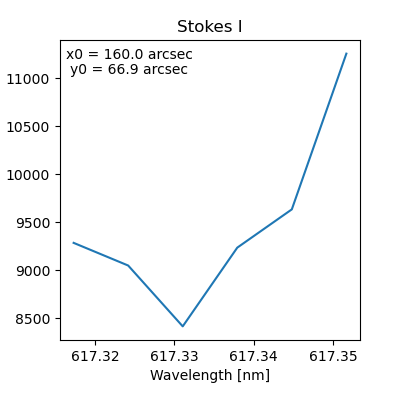

In [9]:
%matplotlib widget

xxx.plot()

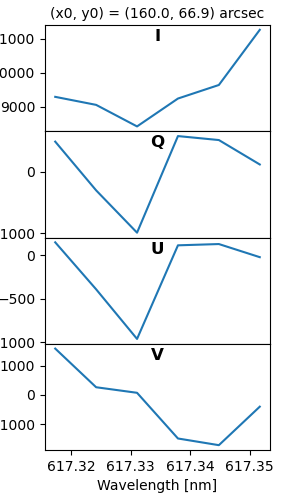

In [30]:
%matplotlib widget

lvl1_c_HMI.plot(coords=test_SkyC_1)

In [12]:
kkk = lvl1_c_HMI.data[:,:,coords_pix[0], coords_pix[1]]

In [80]:
ttt = lvl1_c_HMI.data[0,0,:,:]

In [90]:
test_SkyC_1.Tx

<Longitude 160. arcsec>

In [93]:
lvl1_c_HMI.I_profile(coords=test_SkyC_1).meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
                  (-1037.30224047, -1032.05354828)>),
             ('stokes', 'I'),
             ('x0_pix', 2374),
             ('y0_pix', 2179),
             ('x0', <Longitude 159.99962562 arcsec>),
             ('y0', <Latitude 66.88766824 arcsec>)])

In [92]:
lvl1_c_HMI.meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
                  (-1037.30224047, -1032.05354828)>)])

In [103]:
test_SkyC_1

<SkyCoord (Helioprojective: obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
    (160., 67.)>

In [105]:
lvl1_c_HMI.data.shape

(4, 6, 4098, 4098)

In [117]:
I=lvl1_c_HMI.I

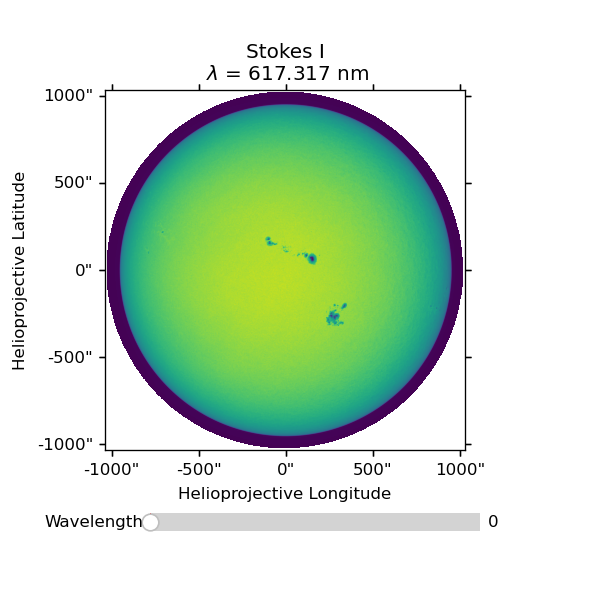

In [119]:
%matplotlib widget

I.plot()

OrderedDict([('frame', <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
    (-28.62468097, -23.38890748)>), ('x0_pix', 374), ('y0_pix', 179), ('x0', <Longitude 159.99962562 arcsec>), ('y0', <Latitude 66.88851342 arcsec>)])
374 179


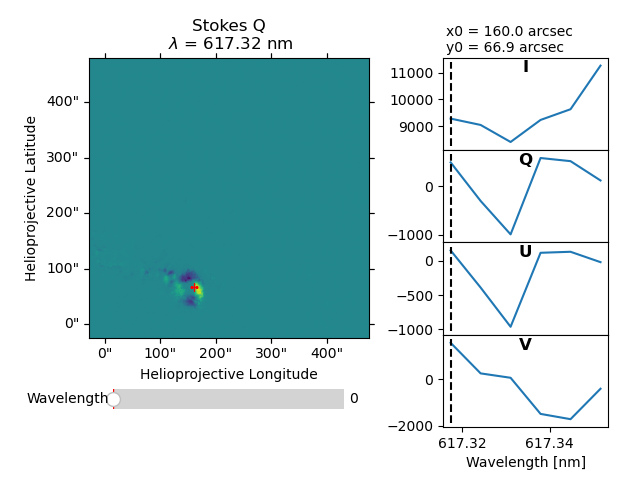

In [9]:
%matplotlib widget
lvl1_c_HMI[:,:,2000:3000,2000:3000].plot(coords=test_SkyC_1, context=1)

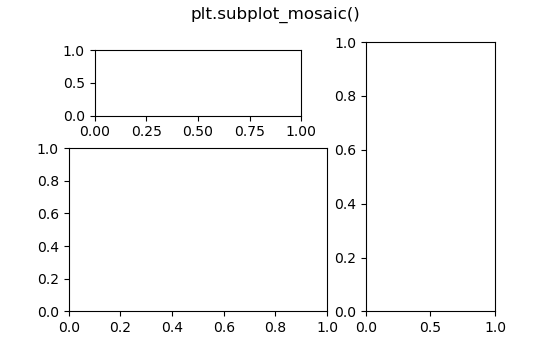

In [144]:
%matplotlib widget

gs_kw = dict(width_ratios=[2.0, 1], height_ratios=[1, 2])
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              gridspec_kw=gs_kw, figsize=(5.5, 3.5),
                              constrained_layout=False)
#for k in axd:
#    annotate_axes(axd[k], f'axd["{k}"]', fontsize=14)
fig.suptitle('plt.subplot_mosaic()')

l, b, w, h = axd['upper left'].get_position().bounds
#ll, bb, ww, hh = CB.ax.get_position().bounds
#CB.ax.set_position([ll, b + 0.1*h, ww, h*0.8])

axd['upper left'].set_position([l + w*0.1, b + h*0.1, w*0.8, h*0.8])

In [133]:
axd['upper left'].set_position?

Object `set_position` not found.


In [ ]:
axd['upper left'].set_position

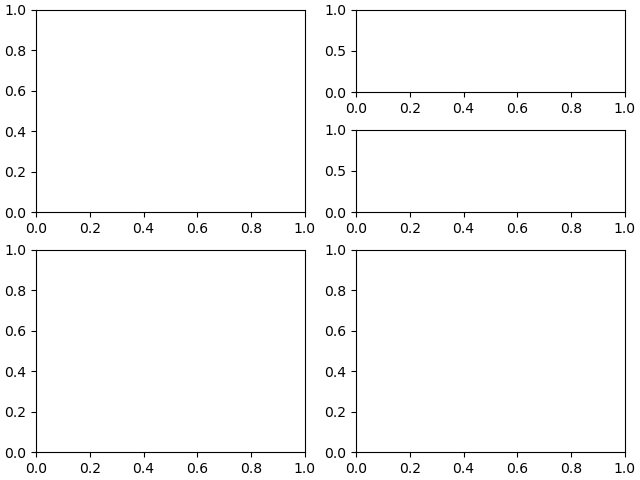

In [32]:
%matplotlib widget

inner = [['innerA'],
         ['innerB']]
outer = [['upper left',  inner],
          ['lower left', 'lower right']]

fig, axd = plt.subplot_mosaic(outer, constrained_layout=True)
#for k in axd:
#    annotate_axes(axd[k], f'axd["{k}"]')

ValueError: There are duplicate keys {'I', 'U', 'Q', 'V'} between the outer layout
array([['upper left', list([['I'], ['Q'], ['U'], ['V']])],
       ['lower left', list([['I'], ['Q'], ['U'], ['V']])]], dtype=object)
and the nested layout
[['I']
 ['Q']
 ['U']
 ['V']]

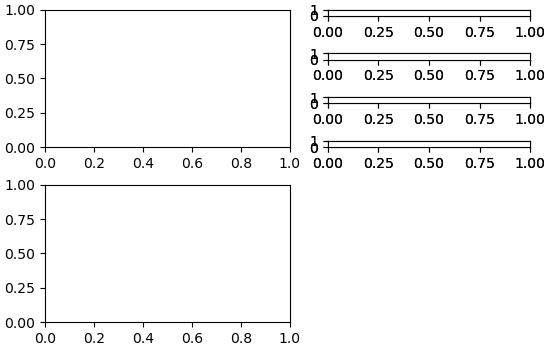

In [49]:
%matplotlib widget

#gs_kw = dict(width_ratios=[1, 1], height_ratios=[1, 1])

inner = [['I'], ['Q'], ['U'], ['V']]
#inner = [['innerA'],
#         ['innerB']]
fig, axd = plt.subplot_mosaic([['upper left', inner],
                               ['lower left', inner]],
                              figsize=(5.5, 3.5),
                              constrained_layout=True)
#for k in axd:
#    annotate_axes(axd[k], f'axd["{k}"]', fontsize=14)
fig.suptitle('plt.subplot_mosaic()')

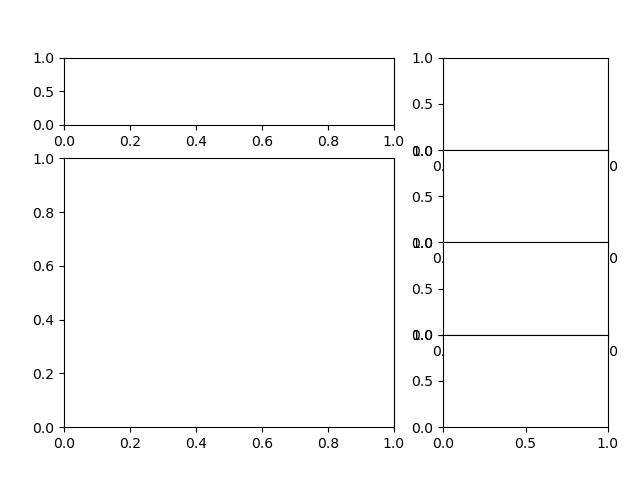

In [79]:
fig = plt.figure(constrained_layout=False)
gs0 = fig.add_gridspec(1, 2, left=0.1, right=0.95, width_ratios=[2, 1],
                      hspace=0.2, wspace=0.2)

gs00 = gs0[0].subgridspec(2, 1, wspace=0.0, hspace=0.2, width_ratios=[1], height_ratios=[1, 4])
gs01 = gs0[1].subgridspec(4, 1, hspace=0.0, wspace=0.0)

context_ax = []
for a in range(2):
    for b in range(1):
        context_ax.append(fig.add_subplot(gs00[a, b]))
stokes_ax = []
for a in range(4):
    stokes_ax.append(fig.add_subplot(gs01[a]))
    
#fig.suptitle('nested gridspecs')

In [77]:
ax

<AxesSubplot:>

# Load Hinode/SP data series

In [10]:
# Select a date and time to search for observations.
#user_date = astropy.time.Time(datetime.datetime(2016, 7, 28, 23, 57, 0), scale='tai')
#user_date = '20201101_200602'  # Quiet Sun
#user_date = '20170822_171104'   # AR near limb
user_date = '20170905_030404'  # AR near disc center

# Find the nearest set of Stokes and corresponding inversion results.
#all_fnames_stokes, all_fnames_magvec = get_HMI_data(user_date, user_notify='gdima@hawaii.edu', download=False)
magnetic_params=['Field_Strength', 
                 'Field_Inclination', 
                 'Field_Azimuth',
                 'Stray_Light_Fill_Factor']
head_all, head1, head2, lvl1_data, lvl1_wcs, lvl2_data, lvl2_wcs = \
    get_SP_data(user_date, magnetic_params=magnetic_params)

In [11]:
# Create the Hinode StokesCube
lvl1_c_SP = stokespy.StokesCube(lvl1_data, lvl1_wcs)
lvl2_c_SP = stokespy.MagVectorCube(lvl2_data, lvl2_wcs, magnetic_params=magnetic_params)
print('SP Stokes cube shape: ', lvl1_c_SP.data.shape)
print('SP magnetic cube shape: ', lvl2_c_SP.data.shape)

SP Stokes cube shape:  (4, 112, 512, 485)
SP magnetic cube shape:  (4, 512, 485)


In [9]:
# Information from the WCS attached to the cube.
# Note the index ordering is different between the data array and the header information.
# 
lvl1_c_SP.wcs, lvl2_c_SP.wcs, lvl2_c_SP.magnetic_axis

(WCS Keywords
 
 Number of WCS axes: 4
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
 CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
 CRPIX : 243.0  256.5  56.5  0.0  
 PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
 PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
 PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  2.1549e-12  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.03610083333333333  0.011277222222222221  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
 NAXIS : 0  0,
 ['Field_Strength',
  'Field_Inclination',
  'Field_Azimuth',
  'Stray_Light_Fill_Factor'])

In [10]:
lvl1_c_SP.spectral_axis.to(u.nm)

<Quantity [630.08840305, 630.09055795, 630.09271285, 630.09486775,
           630.09702265, 630.09917755, 630.10133245, 630.10348735,
           630.10564225, 630.10779715, 630.10995205, 630.11210695,
           630.11426185, 630.11641675, 630.11857165, 630.12072655,
           630.12288145, 630.12503635, 630.12719125, 630.12934615,
           630.13150105, 630.13365595, 630.13581085, 630.13796575,
           630.14012065, 630.14227555, 630.14443045, 630.14658535,
           630.14874025, 630.15089515, 630.15305005, 630.15520495,
           630.15735985, 630.15951475, 630.16166965, 630.16382455,
           630.16597945, 630.16813435, 630.17028925, 630.17244415,
           630.17459905, 630.17675395, 630.17890885, 630.18106375,
           630.18321865, 630.18537355, 630.18752845, 630.18968335,
           630.19183825, 630.19399315, 630.19614805, 630.19830295,
           630.20045785, 630.20261275, 630.20476765, 630.20692255,
           630.20907745, 630.21123235, 630.21338725, 630.21554

In [11]:
lvl1_c_SP.wcs.world_axis_units

['deg', 'deg', 'm', '']

OrderedDict([('frame', <Helioprojective Coordinate (obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
    (58.05512713, -41.15637222)>), ('x0_pix', 343), ('y0_pix', 338), ('x0', <Longitude 159.97413803 arcsec>), ('y0', <Latitude 66.99618078 arcsec>)])
343 338


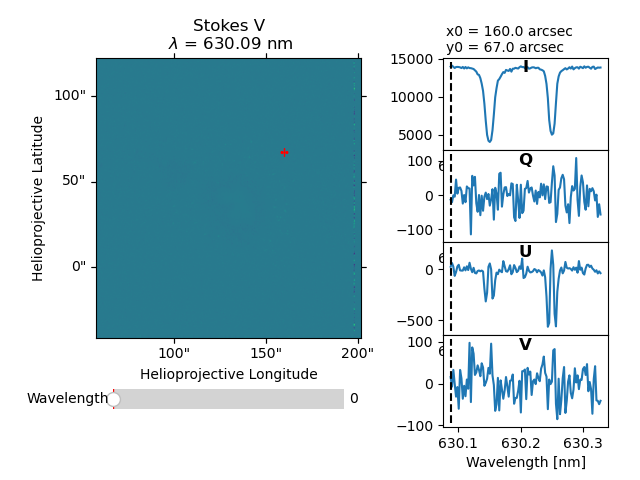

In [15]:
%matplotlib widget

lvl1_c_SP.plot(coords=test_SkyC_1, context=3)

## Test the image central coordinates

In [11]:
# The wcs contructor converts inputs into 'deg' and 'm'.
# This number is comparable to the values using
print('Spatial sampling along X (arcsec): ', \
      lvl1_wcs.wcs.cdelt[0]*u.deg.to(u.arcsec), 151/512)

print('Spatial sampling along Y (arcsec): ', \
      lvl1_wcs.wcs.cdelt[1]*u.deg.to(u.arcsec), 162/511)

print('Level1 FOV center coordinates (x,y)[arcsec] = :',\
      lvl1_wcs.wcs.crval[0]*u.deg.to(u.arcsec), \
      lvl1_wcs.wcs.crval[1]*u.deg.to(u.arcsec))

print('Level2 FOV center coordinates (x,y)[arcsec] = :',\
      lvl2_wcs.wcs.crval[0]*u.deg.to(u.arcsec), \
      lvl2_wcs.wcs.crval[1]*u.deg.to(u.arcsec))


Spatial sampling along X (arcsec):  0.29714 0.294921875
Spatial sampling along Y (arcsec):  0.319978 0.31702544031311153
Level1 FOV center coordinates (x,y)[arcsec] = : 129.963 40.598
Level2 FOV center coordinates (x,y)[arcsec] = : 129.963 40.598


WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
CRVAL : 0.03610083333333333  0.011277222222222221  6.30208e-07  0.0  
CRPIX : 243.0  256.5  56.5  0.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : 8.253888888888889e-05  8.888277777777778e-05  2.1549e-12  1.0  
NAXIS : 0  0

In [14]:
lvl1_c_SP.frame

<Helioprojective Coordinate (obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
    (58.05512713, -41.15637222)>

In [15]:
print(head1['XCEN'], head2['XCEN'], head1['YCEN'],head2['YCEN'])

55.8102 96.301 40.8188 40.5247


In [16]:
print(head1['XSCALE'], head2['XSCALE'], head1['YSCALE'],head2['YSCALE'])

0.297140002251 0.29714 0.319979995489 0.319978


In [17]:
print(head1['NAXIS1'], head2['NAXIS1'], head1['NAXIS2'], head2['NAXIS2'])

112 485 512 512


In [18]:
lv1_wcs.wcs.crpix

array([243. , 256.5,  56.5,   0. ])

In [19]:
# Look at the centeral position for each header.
nslit = len(head_all)
xcen_a = np.zeros(nslit)
ycen_a = np.zeros(nslit)

for i in range(nslit):
    xcen_a[i] = head_all[i]['XCEN']
    ycen_a[i] = head_all[i]['YCEN']

In [20]:
%matplotlib widget

plt.plot(xcen_a, label='Xcen')
plt.plot(ycen_a, label='Ycen')
print(np.median(xcen_a), np.median(ycen_a))
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

129.963 40.598


# Co-align Hinode and HMI observations

## Compute the magnetic flux densities.

In [11]:
### Hinode data ###
lvl2_c_SP.magnetic_axis

['Field_Strength',
 'Field_Inclination',
 'Field_Azimuth',
 'Stray_Light_Fill_Factor']

In [6]:
mag_fden_SP = lvl2_c_SP.data[3,:,:]*\
            lvl2_c_SP[0,:,:].data*\
            np.cos(np.radians(lvl2_c_SP[1,:,:].data))
print('Hinode magnetic density map shape: ', mag_fden_SP.shape)

Hinode magnetic density map shape:  (512, 485)


In [7]:
# Create a new object that only holds the magnetic density map.
# This preserves WCS.
mag_fden_SP_map = stokespy.MagVectorCube(mag_fden_SP.reshape((1,mag_fden_SP.shape[0], mag_fden_SP.shape[1])), 
                                         lvl2_c_SP.wcs, magnetic_params=['Mag_flux'])

In [14]:
mag_fden_SP_map.data.shape

(1, 512, 485)

In [16]:
mag_fden_SP_map.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.03610083333333333  0.011277222222222221  0.0  
CRPIX : 243.0  256.5  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
NAXIS : 0  0

In [17]:
mag_fden_SP_map

NDCube
------
Dimensions: [  1. 512. 485.] pix
Physical Types of Axes: [(None,), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float64

In [18]:
### HMI data ###
lvl2_c_HMI.magnetic_axis

('B', 'inclination', 'azimuth')

In [8]:
mag_fden_HMI = lvl2_c_HMI.data[0,:,:]*\
                np.cos(np.radians(lvl2_c_HMI.data[1,:,:]))
print('HMI magnetic density map shape: ', mag_fden_HMI.shape)

HMI magnetic density map shape:  (4098, 4098)


In [20]:
mag_fden_HMI.shape

(4098, 4098)

In [21]:
lvl2_c_HMI[0,:,:].wcs.low_level_wcs

SlicedLowLevelWCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None

World Dim  Axis Name  Physical Type                   Units
        0  None       custom:pos.helioprojective.lon  deg
        1  None       custom:pos.helioprojective.lat  deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes

In [10]:
# Reshape the array into
tt = mag_fden_HMI.reshape((1,mag_fden_HMI.shape[0], mag_fden_HMI.shape[1]))

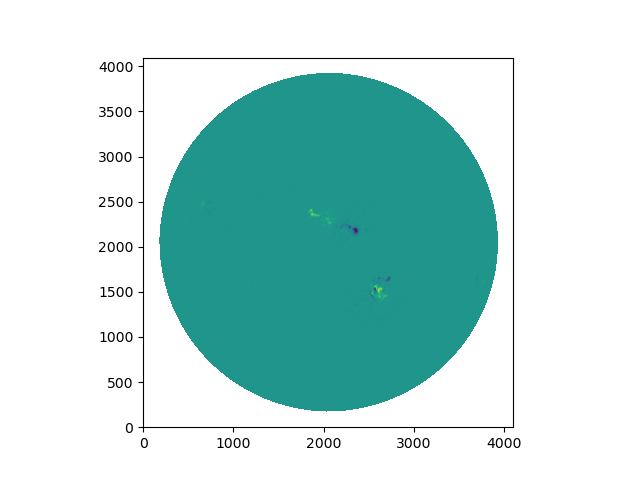

In [11]:
%matplotlib widget

plt.imshow(tt[0,:,:], origin='lower')

In [12]:
# Create a new object with 3D
# This preserves WCS.
mag_fden_HMI_map = stokespy.MagVectorCube(mag_fden_HMI.reshape((1,mag_fden_HMI.shape[0], mag_fden_HMI.shape[1])), lvl2_c_HMI.wcs, 
                                          magnetic_params=['Mag_flux'])

In [22]:
mag_fden_HMI_map.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2057.7563593149  2047.3749883579  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00014009532001283  0.00014009532001283  1.0  
NAXIS : 0  0

## Calculate the coordinates of the HMI map

In [13]:
### Coordinates ###
# HINODE_YCOORDS
print(mag_fden_SP_map.coord1_axis(0)[0].Ty, mag_fden_SP_map.coord1_axis(0)[-1].Ty) 
# HINODE_XCOORDS
print(mag_fden_SP_map.coord2_axis(0)[0].Tx, mag_fden_SP_map.coord2_axis(0)[-1].Tx) 

-41.1564arcsec 122.352arcsec
58.0551arcsec 201.871arcsec


In [15]:
### Calculate the corresponding coordinates in HMI
hmi_index_y, hmi_index_x = mag_fden_HMI_map[0,:,:].wcs.low_level_wcs.world_to_array_index_values([mag_fden_SP_map.coord2_axis(0)[0].Tx.to(u.deg).value, 
        
                                                                                                  mag_fden_SP_map.coord2_axis(0)[-1].Tx.to(u.deg).value],
                                                   [mag_fden_SP_map.coord1_axis(0)[0].Ty.to(u.deg).value,
                                                   mag_fden_SP_map.coord1_axis(0)[-1].Ty.to(u.deg).value])

In [16]:
hmi_index_y, hmi_index_x

(array([1965, 2289]), array([2172, 2457]))

In [19]:
### Create a cropped HMI map at the approximate coordinates.

#hmi_index_y[0]-pix_pad:hmi_index_y[1]+pix_pad, \
#hmi_index_x[0]-pix_pad:hmi_index_x[1]+pix_pad]

pix_pad = 120
cropped_hmi = mag_fden_HMI_map.data[0, hmi_index_y[0]-pix_pad:hmi_index_y[1]+pix_pad, \
                                    hmi_index_x[0]-pix_pad:hmi_index_x[1]+pix_pad]
# For comparison purposes.
cropped_hmi_no_pad = mag_fden_HMI_map.data[0, hmi_index_y[0]:hmi_index_y[1], \
                                    hmi_index_x[0]:hmi_index_x[1]]

In [20]:
cropped_hmi.shape

(564, 525)

## Change Hinode map resolution to match HMI

In [21]:
tmp_hinode_data_0 = ndimage.gaussian_filter(mag_fden_SP_map[0,:,:].data,1.3)
tmp_hinode_data = ndimage.zoom(tmp_hinode_data_0, \
                                [(hmi_index_y[1]-hmi_index_y[0])/tmp_hinode_data_0.shape[0], \
                                    (hmi_index_x[1]-hmi_index_x[0])/tmp_hinode_data_0.shape[1]])

print('Zoom values: ', [(hmi_index_y[1]-hmi_index_y[0])/tmp_hinode_data_0.shape[0], \
                                    (hmi_index_x[1]-hmi_index_x[0])/tmp_hinode_data_0.shape[1]])

Zoom values:  [0.6328125, 0.5876288659793815]


In [22]:
tmp_hinode_data_0.shape, tmp_hinode_data.shape

((512, 485), (324, 285))

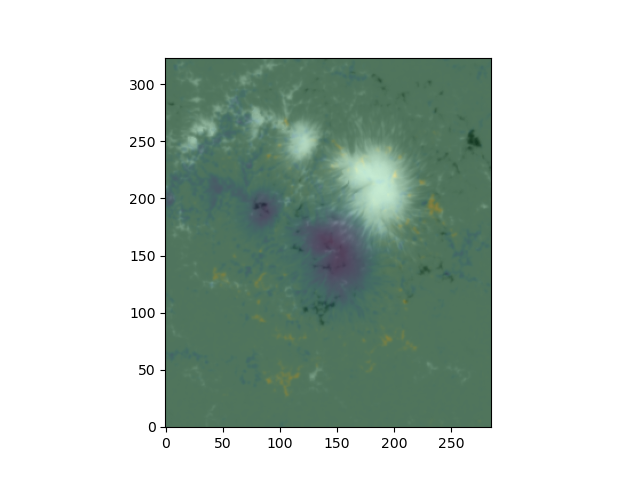

In [23]:
# Plot the maps.

%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

plt.subplots_adjust(wspace=0.4)

ax1.imshow(tmp_hinode_data, origin='lower')
ax1.imshow(cropped_hmi_no_pad, origin='lower', cmap='Greys', alpha=0.7)

## Perform the 1st coalignment

In [26]:
# Use the sunpy coalignment routine to get an initial idea where the degraded Hinode data
# should be on the padded HMI map.  
thisxyshift = coalignment.calculate_shift(cropped_hmi, tmp_hinode_data)
print(thisxyshift)

(<Quantity 180.0559652 pix>, <Quantity 154.65463902 pix>)


In [27]:
thisxyshift[0].value - pix_pad, thisxyshift[1].value - pix_pad 

(60.05596519707399, 34.65463902366059)

In [28]:
# Recrop the HMI data taking into account the shift.
hmi_index_x_new = np.around(hmi_index_x+(thisxyshift[1].value-pix_pad)).astype(int)
hmi_index_y_new = np.around(hmi_index_y+(thisxyshift[0].value-pix_pad)).astype(int)
hmi_data = mag_fden_HMI_map.data[0, hmi_index_y_new[0]:hmi_index_y_new[1],
                                 hmi_index_x_new[0]:hmi_index_x_new[1]]


In [29]:
hmi_index_x_new - hmi_index_x, hmi_index_y_new - hmi_index_y 

(array([35, 35]), array([60, 60]))

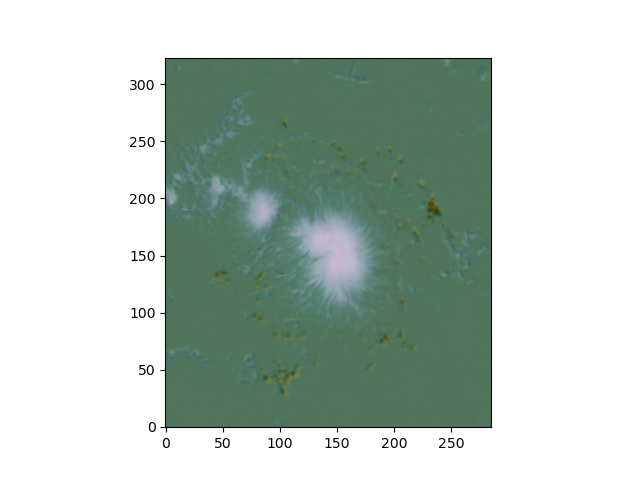

In [30]:
# Plot the maps.

%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

plt.subplots_adjust(wspace=0.4)

ax1.imshow(tmp_hinode_data, origin='lower')
ax1.imshow(hmi_data, origin='lower', cmap='Greys', alpha=0.7)


## Reproject the WCS enabled objects.

In [33]:
mag_fden_HMI_map.data.shape,mag_fden_HMI_map.wcs

((1, 4098, 4098),
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.0  0.0  0.0  
 CRPIX : 2057.7563593149  2047.3749883579  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
 PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 0.00014009532001283  0.00014009532001283  1.0  
 NAXIS : 0  0)

In [34]:
mag_fden_SP_map.data.shape,mag_fden_SP_map.wcs

((1, 512, 485),
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.03610083333333333  0.011277222222222221  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
 NAXIS : 0  0)

In [36]:
thisxyshift[0].value - pix_pad, thisxyshift[1].value - pix_pad

(60.05596519707396, 34.65463902366062)

In [113]:
orig_map.wcs.low_level_wcs._wcs.wcs.crval

array([0.03610083, 0.01127722, 0.        ])

In [109]:
reproj_map[100:200,100:200].wcs.low_level_wcs._wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.036100833333333  0.011277222222222  0.0  
CRPIX : 208.0  196.5  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 8.2538888888889e-05  8.8882777777778e-05  1.0  
NAXIS : 0  0

In [ ]:
reproj_map[100:200,100:200].wcs.low_level_wcs._wcs

In [127]:
kkk = orig_map[200:300,200:300]

In [128]:
kkk.wcs.low_level_wcs.array_index_to_world_values(0,0)

[array(0.0326342), array(0.00634423)]

In [117]:
target_wcs_x = astropy.wcs.WCS(kkk.wcs.low_level_wcs._wcs.to_header())

In [121]:
target_wcs_x.get_axis_types

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.036100833333333  0.011277222222222  0.0  
CRPIX : 243.0  256.5  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 8.2538888888889e-05  8.8882777777778e-05  1.0  
NAXIS : 0  0

In [133]:
coord_orig = kkk.wcs.low_level_wcs.array_index_to_world_values(0,0)
#coord_shifted = reproj_map.wcs.array_index_to_world_values(0,0)
print('Original bottom left x,y: ', (coord_orig*u.deg).to(u.arcsecond))
#print('Reprojected bottom left x,y: ', (coord_shifted*u.deg).to(u.arcsecond))

Original bottom left x,y:  [117.48311998  22.839221  ] arcsec


### Reproject Hinode SP 

The Hinode plate scale is different than for HMI.
The cross-correlation calculates pixel shift values in HMI pixels.

In [195]:
hmi_xy_shift = [thisxyshift[1].value - pix_pad, thisxyshift[0].value - pix_pad]

In [196]:
lvl1_c_HMI.wcs.wcs.cdelt[0:2]*hmi_xy_shift


array([0.00485495, 0.00841356])

In [216]:
new_cen = mag_fden_SP_map.wcs.wcs.crval[0:2] + \
            lvl1_c_HMI.wcs.wcs.cdelt[0:2]*hmi_xy_shift

In [217]:
new_cen

array([0.04095579, 0.01969078])

In [78]:
# Calculate the new center coordinates
new_cen = mag_fden_SP_map.wcs.wcs.crpix[0:2] - \
         [(np.around(thisxyshift[1].value - pix_pad)).astype(int),
          (np.around(thisxyshift[0].value - pix_pad)).astype(int)]
print(new_cen)

[208.  196.5]


In [79]:
mag_fden_SP_map.wcs.wcs.crpix[0:2]

array([243. , 256.5])

In [33]:
mag_fden_SP_map.data.shape, mag_fden_SP_map.wcs

((1, 512, 485),
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.03610083333333333  0.011277222222222221  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
 NAXIS : 0  0)

In [34]:
lvl2_c_SP.data.shape

(4, 512, 485)

In [218]:
# Create a copy of the WCS object to modify
orig_cube = mag_fden_SP_map
target_wcs_x = astropy.wcs.WCS(orig_cube.wcs.to_header())
# Apply the translation.
#target_wcs_x.wcs.crpix[0:2] = new_cen
target_wcs_x.wcs.crval[0:2] = new_cen
print(target_wcs_x)

reproj_cube = orig_cube.reproject_to(target_wcs=target_wcs_x, 
                                shape_out=orig_cube.data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.04095578607728217  0.019690781885185683  0.0  
CRPIX : 243.0  256.5  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 8.2538888888889e-05  8.8882777777778e-05  1.0  
NAXIS : 0  0


In [219]:
# Make a new object with the shifted coordinate system.
reproj_SP_map = stokespy.MagVectorCube(lvl2_c_SP.data, target_wcs_x,
                                       magnetic_params=lvl2_c_SP.magnetic_axis)


In [237]:
reproj_SP_map.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.04095578607728217  0.019690781885185683  0.0  
CRPIX : 243.0  256.5  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 8.2538888888889e-05  8.8882777777778e-05  1.0  
NAXIS : 0  0

In [235]:
# Create a copy of the WCS object to modify
orig_cube = lvl1_c_SP
target_wcs_x = astropy.wcs.WCS(orig_cube.wcs.to_header())
# Apply the translation.
#target_wcs_x.wcs.crpix[0:2] = new_cen
target_wcs_x.wcs.crval[0:2] = new_cen

reproj_SP_map_1 = stokespy.StokesCube(lvl1_c_SP.data, target_wcs_x)

In [236]:
reproj_SP_map_1.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'STOKES'  
CRVAL : 0.04095578607728217  0.019690781885185683  6.30208e-07  0.0  
CRPIX : 243.0  256.5  56.5  0.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : 8.2538888888889e-05  8.8882777777778e-05  2.1549e-12  1.0  
NAXIS : 0  0

In [239]:
# Crop to the approximate coordinates that Hinode/SP is observing.

# Increase the size of the bounding box so the cross-correlation works better.
offset = 0*u.arcsec
bottom_left_skycoord = SkyCoord(Tx = reproj_SP_map_1.coord1_axis(0)[0].Tx-offset, \
                               Ty = reproj_SP_map_1.coord1_axis(0)[0].Ty-offset, \
                               frame = lvl1_c_HMI.meta['frame'])

top_right_skycoord = SkyCoord(Tx = reproj_SP_map_1.coord2_axis(512)[-1].Tx+offset, \
                               Ty = reproj_SP_map_1.coord1_axis(512)[-1].Ty+offset, \
                               frame = lvl1_c_HMI.meta['frame'])

#bottom_left_skycoord = SkyCoord(-700 * u.arcsec, -700 * u.arcsec)
#top_right_skycoord = SkyCoord(700* u.arcsec, 700 * u.arcsec)

cropped_map = lvl1_c_HMI.crop((bottom_left_skycoord, None, None), (top_right_skycoord, None, None))

In [241]:
cropped_map.data.shape

(4, 6, 325, 286)

In [176]:
orig_cube.wcs,reproj_cube.wcs

(WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.03610083333333333  0.011277222222222221  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.04095578607728217  0.019690781885185683  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.2538888888889e-05  8.8882777777778e-05  1.0  
 NAXIS : 0  0)

In [178]:
orig_cube.data.shape,reproj_cube.data.shape

((1, 512, 485), (1, 512, 485))

In [179]:
orig_cube.data - reproj_cube.data

array([[[164.19190858, 115.21225181,  65.6711805 , ...,          nan,
                  nan,          nan],
        [635.04189344, 547.05211673, 422.71788614, ...,          nan,
                  nan,          nan],
        [894.469989  , 888.36611911, 668.55859079, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])

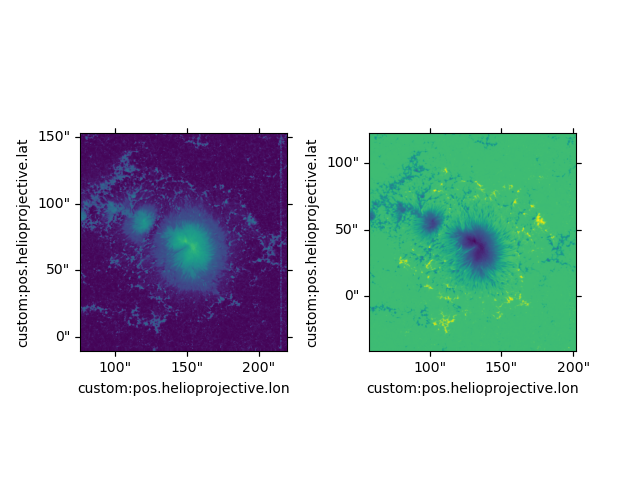

In [221]:
%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

#ax1 = plt.subplot(121, projection=reproj_cube[0,:,:].wcs)
ax1 = plt.subplot(121, projection=reproj_SP_map[0,:,:].wcs)
ax2 = plt.subplot(122, projection=orig_cube[0,:,:].wcs)
#ax2 = plt.subplot(122, projection=mag_fden_HMI_map[0,:,:].wcs)

plt.subplots_adjust(wspace=0.4)

#ax1.imshow(reproj_cube[0,:,:].data, origin='lower')
ax1.imshow(reproj_SP_map[0,:,:].data, origin='lower')
ax2.imshow(orig_cube[0,:,:].data, origin='lower')
#ax2.imshow(mag_fden_HMI_map[0,:,:].data, origin='lower')

#lvl.plot(ax=ax1)
#cropped_map.plot(ax=ax2)

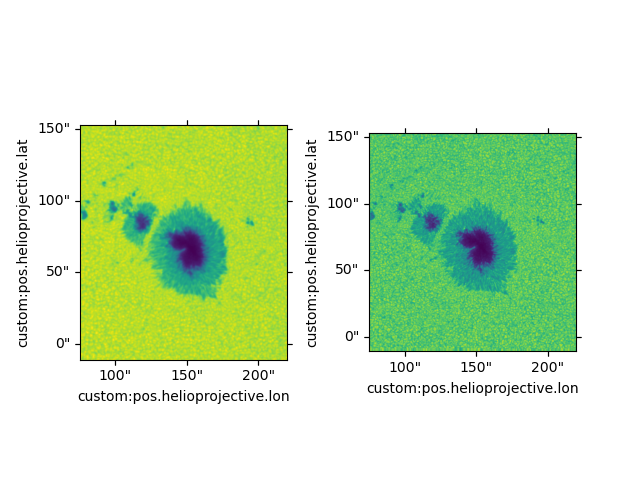

In [285]:
%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

#ax1 = plt.subplot(121, projection=reproj_cube[0,:,:].wcs)
ax1 = plt.subplot(121, projection=cropped_map[0,0,:,:].wcs)
ax2 = plt.subplot(122, projection=reproj_SP_map_1[0,0,:,:].wcs)
#ax2 = plt.subplot(122, projection=mag_fden_HMI_map[0,:,:].wcs)

plt.subplots_adjust(wspace=0.4)

#ax1.imshow(reproj_cube[0,:,:].data, origin='lower')
ax1.imshow(cropped_map[0,0,:,:].data, origin='lower')
#ax2.imshow(orig_cube[0,:,:].data, origin='lower')
#ax2.imshow(mag_fden_HMI_map[0,:,:].data, origin='lower')
ax2.imshow(reproj_SP_map_1[0,0,:,:].data, origin='lower')
#lvl.plot(ax=ax1)
#cropped_map.plot(ax=ax2)


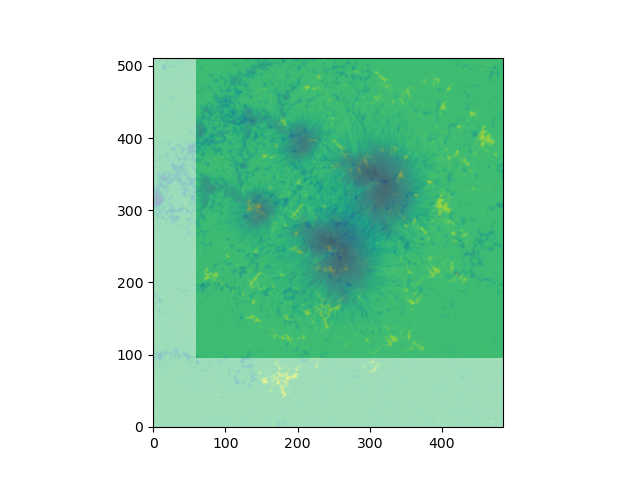

In [201]:
%matplotlib widget

plt.imshow(reproj_cube[0,:,:].data, origin='lower')
plt.imshow(orig_cube[0,:,:].data, origin='lower', alpha=0.5)

In [202]:
orig_map = orig_cube._magnetic_map(0)
reproj_map = reproj_cube._magnetic_map(0)

In [207]:
# Find a point in the image.
# Array indices are in python (y,x) notation.
# Pixel indices are in image (x,y) coordinates.
# 

# 243.0  256.5

coord_orig = orig_map.wcs.array_index_to_world_values(243,256.6)
coord_shifted = reproj_map.wcs.array_index_to_world_values(243, 256.6)
print('Original bottom left x,y: ', (coord_orig*u.deg).to(u.arcsecond))
print('Reprojected bottom left x,y: ', (coord_shifted*u.deg).to(u.arcsecond))

Original bottom left x,y:  [134.30124407  36.59827499] arcsec
Reprojected bottom left x,y:  [116.82341412   6.30946021] arcsec


In [209]:
coord_shifted*u.deg

<Quantity [0.03245095, 0.00175263] deg>

In [208]:
orig_cube.wcs,reproj_cube.wcs

(WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.03610083333333333  0.011277222222222221  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.253888888888889e-05  8.888277777777778e-05  1.0  
 NAXIS : 0  0,
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
 CRVAL : 0.031245880589384496  0.0028636625592587603  0.0  
 CRPIX : 243.0  256.5  0.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
 PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
 CDELT : 8.2538888888889e-05  8.8882777777778e-05  1.0  
 NAXIS : 0  0)

In [322]:
# Test Sky coordinate

test_skycoord0 = SkyCoord(Tx = 131 * u.arcsec, Ty = 37 * u.arcsec, \
                               frame = lvl1_c_HMI.meta['frame'])
test_skycoord1 = SkyCoord(Tx = 160 * u.arcsec, Ty = 67 * u.arcsec, \
                               frame = lvl1_c_HMI.meta['frame'])
#test_skycoord1 = SkyCoord(Tx = 148 * u.arcsec, Ty = 67 * u.arcsec, \
#                               frame = lvl1_c_HMI.meta['frame'])

In [323]:
orig_test_ind = orig_map.wcs.world_to_array_index(test_skycoord0)
reproj_test_ind = reproj_SP_map[0,:,:].wcs.world_to_array_index(test_skycoord1)
print(orig_test_ind)
print(reproj_test_ind)
print(orig_test_ind[0] - reproj_test_ind[0], orig_test_ind[1] - reproj_test_ind[1])

(244, 245)
(243, 284)
1 -39


In [324]:
HMI_test_ind = lvl1_c_HMI[0,0,:,:].wcs.world_to_array_index(test_skycoord1)
cropped_test_ind = cropped_map[0,0,:,:].wcs.world_to_array_index(test_skycoord1)
reproj_SP_test_ind = reproj_SP_map_1[0,0,:,:].wcs.world_to_array_index(test_skycoord1)
print(HMI_test_ind)
print(cropped_test_ind)
print(reproj_SP_test_ind)
#print(orig_test_ind[0] - reproj_test_ind[0], orig_test_ind[1] - reproj_test_ind[1])

(2179, 2374)
(154, 167)
(243, 284)


In [293]:
coord_orig = orig_map.wcs.array_index_to_world_values(*orig_test_ind)
coord_shifted = reproj_map.wcs.array_index_to_world_values(*reproj_test_ind)
print('Original bottom left x,y: ', (coord_orig*u.deg).to(u.arcsecond))
print('Shifted bottom left x,y: ', (coord_shifted*u.deg).to(u.arcsecond))

Original bottom left x,y:  [130.85442001  36.918253  ] arcsec
Shifted bottom left x,y:  [113.07945012   6.30946021] arcsec


In [325]:
# Test the 1D profiles.

HMI_V = lvl1_c_HMI.V_profile(test_skycoord1)
SP_V = reproj_SP_map_1.V_profile(test_skycoord1)

In [315]:
HMI_V.meta,SP_V.meta

(OrderedDict([('frame',
               <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                   (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
                   (75.77434791, -10.78032827)>),
              ('stokes', 'V'),
              ('x0_pix', 2358),
              ('y0_pix', 2179),
              ('x0', <Longitude 151.9301398 arcsec>),
              ('y0', <Latitude 66.88766824 arcsec>)]),
 OrderedDict([('frame',
               <Helioprojective Coordinate (obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
                   (75.53295834, -10.86755927)>),
              ('stokes', 'V'),
              ('x0_pix', 257),
              ('y0_pix', 243),
              ('x0', <Longitude 151.89792953 arcsec>),
              ('y0', <Latitude 66.88708572 arcsec>)]))

Text(0.5, 1.0, 'SDO/HMI $\\lambda$=617.3 nm')

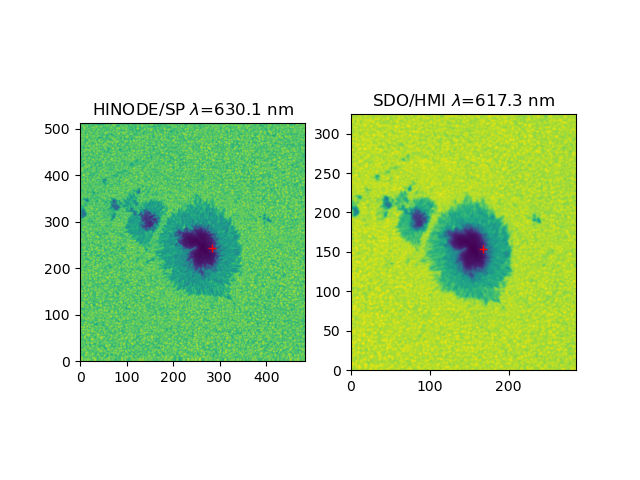

In [332]:
%matplotlib widget 

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
wav = 0
ax1.imshow(reproj_SP_map_1.data[0,wav,:,:], origin='lower')
ax2.imshow(cropped_map.data[0,wav,:,:], origin='lower')

#print(HMI_test_ind)
#print(cropped_test_ind)
#print(reproj_SP_test_ind)

ax1.plot(reproj_SP_test_ind[1], reproj_SP_test_ind[0], '+r')
ax2.plot(cropped_test_ind[1], cropped_test_ind[0], '+r')

ax1.set_title('HINODE/SP $\lambda$=' + 
              str(np.round(reproj_SP_map_1.spectral_axis[wav].to(u.nm), 1)))
ax2.set_title('SDO/HMI $\lambda$=' + 
              str(np.round(cropped_map.spectral_axis[wav].to(u.nm), 1)))

In [333]:
print(lvl2_c_HMI.data[0, HMI_test_ind[0], HMI_test_ind[1]])
print(reproj_SP_map.data[0, reproj_SP_test_ind[0], reproj_SP_test_ind[1]])

2711.486778222231
2657.447998046875


In [329]:
reproj_SP_map_1.data.shape

(4, 112, 512, 485)

In [339]:
reproj_SP_test_ind

(243, 284)

TODO1: implement <class 'stokespy.stokespy.StokesCube'>.plot()


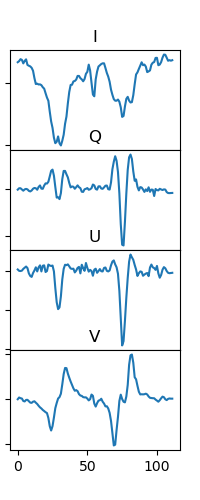

In [340]:
%matplotlib widget
reproj_SP_map_1.plot(coord1=reproj_SP_test_ind[0], 
                     coord2=reproj_SP_test_ind[1])

TODO1: implement <class 'stokespy.stokespy.StokesCube'>.plot()


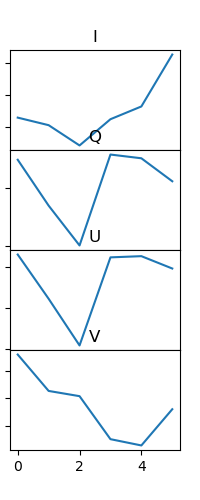

In [341]:
%matplotlib widget

cropped_map.plot(coord1=cropped_test_ind[0], coord2=cropped_test_ind[1])

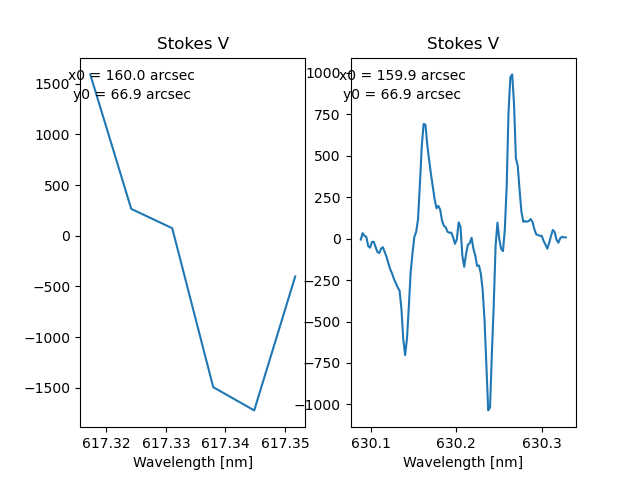

In [328]:
%matplotlib widget

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

HMI_V.plot(ax=ax1)
SP_V.plot(ax=ax2)

In [52]:
orig_map.wcs

SlicedFITSWCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None

World Dim  Axis Name  Physical Type                   Units
        0  None       custom:pos.helioprojective.lon  deg
        1  None       custom:pos.helioprojective.lat  deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes

### Reproject HMI

In [46]:
# Calculate the new center coordinates
new_cen = mag_fden_HMI_map.wcs.wcs.crpix[0:2] - \
         [(np.around(thisxyshift[1].value - pix_pad)).astype(int),
          (np.around(thisxyshift[0].value - pix_pad)).astype(int)]
print(new_cen)

[2022.75635931 1987.37498836]


In [47]:
new_cen - mag_fden_HMI_map.wcs.wcs.crpix[0:2]

array([-35., -60.])

In [122]:
# THIS fails because of how MagVectorCube is defined
# Create a copy of the WCS object to modify

target_wcs_x = astropy.wcs.WCS(mag_fden_HMI_map.wcs.to_header())
# Apply the rotation.
target_wcs_x.wcs.crpix[0:2] = new_cen
print(target_wcs_x)

reproj_cube = mag_fden_HMI_map.reproject_to(target_wcs=target_wcs_x, 
                                shape_out=mag_fden_HMI_map.data.shape, magnetic_params=['test'])

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2092.7563593149  2107.3749883579003  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00014009532001283  0.00014009532001283  1.0  
NAXIS : 0  0


TypeError: reproject_to() got an unexpected keyword argument 'magnetic_params'

In [130]:
# Create a copy of the WCS object to modify
orig_cube = lvl2_c_HMI
target_wcs_x = astropy.wcs.WCS(orig_cube.wcs.to_header())
# Apply the rotation.
target_wcs_x.wcs.crpix[0:2] = new_cen
print(target_wcs_x)

reproj_cube = orig_cube.reproject_to(target_wcs=target_wcs_x, 
                                shape_out=orig_cube.data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2022.7563593148998  1987.3749883579  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00014009532001283  0.00014009532001283  1.0  
NAXIS : 0  0


In [150]:
lvl2_c_SP.data.shape

(4, 512, 485)

In [131]:
reproj_cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'Parameter'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2022.7563593148998  1987.3749883579  0.0  
PC1_1 PC1_2 PC1_3  : 1.0  7.4040177438477e-22  0.0  
PC2_1 PC2_2 PC2_3  : 7.4040177438477e-22  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00014009532001283  0.00014009532001283  1.0  
NAXIS : 0  0

In [ ]:
wcs.wcs.crpix = 0, 2, 2

## Crop the shifted map and compare results

In [111]:
lvl1_c_HMI.meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
                  (-1037.30224047, -1032.05354828)>)])

In [125]:
# Crop to the approximate coordinates that Hinode/SP is observing.

# Increase the size of the bounding box so the cross-correlation works better.
offset = 0*u.arcsec
bottom_left_skycoord = SkyCoord(Tx = lvl2_c_SP.coord1_axis(0)[0].Tx-offset, \
                               Ty = lvl2_c_SP.coord1_axis(0)[0].Ty-offset, \
                               frame = lvl1_c_HMI.meta['frame'])

top_right_skycoord = SkyCoord(Tx = lvl2_c_SP.coord2_axis(512)[-1].Tx+offset, \
                               Ty = lvl2_c_SP.coord1_axis(512)[-1].Ty+offset, \
                               frame = lvl1_c_HMI.meta['frame'])

#bottom_left_skycoord = SkyCoord(-700 * u.arcsec, -700 * u.arcsec)
#top_right_skycoord = SkyCoord(700* u.arcsec, 700 * u.arcsec)

cropped_map = reproj_cube.crop((bottom_left_skycoord, None), (top_right_skycoord, None))

In [133]:
lvl2_c_SP.coord1_axis(0)[0].Tx-offset,lvl2_c_SP.coord1_axis(0)[0].Ty-offset

(<Angle 58.05512713 arcsec>, <Angle -41.15637222 arcsec>)

In [134]:
lvl2_c_SP.coord2_axis(512)[-1].Tx+offset,lvl2_c_SP.coord1_axis(512)[-1].Ty+offset

(<Angle 201.87088411 arcsec>, <Angle 122.35236546 arcsec>)

In [135]:
cropped_map.data.shape

(3, 325, 286)

In [137]:
%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(121, projection=lvl2_c_SP[0,:,:].wcs)
ax2 = plt.subplot(122, projection=cropped_map[0,:,:].wcs)

plt.subplots_adjust(wspace=0.4)

ax1.imshow(lvl2_c_SP[0,:,:].data, origin='lower')
ax2.imshow(cropped_map[0,:,:].data, origin='lower')

#lvl.plot(ax=ax1)
#cropped_map.plot(ax=ax2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

################ Old below ###################

In [21]:
# Select a single wavelength or a range to sum over.
# The entries can be both array indices (int) and wavelength quantities if
# known.

# You can use the StokesCube attribute spectral_axis
# to see which wavelengths are available.
print('HMI spectral axis: ', lvl1_c_HMI.spectral_axis.to(u.nm))
print('Hinode/SP spectral axis: ', lvl1_c_SP.spectral_axis.to(u.nm))

HMI spectral axis:  [617.3173  617.32418 617.33106 617.33794 617.34482 617.3517 ] nm
Hinode/SP spectral axis:  [630.08840305 630.09055795 630.09271285 630.09486775 630.09702265
 630.09917755 630.10133245 630.10348735 630.10564225 630.10779715
 630.10995205 630.11210695 630.11426185 630.11641675 630.11857165
 630.12072655 630.12288145 630.12503635 630.12719125 630.12934615
 630.13150105 630.13365595 630.13581085 630.13796575 630.14012065
 630.14227555 630.14443045 630.14658535 630.14874025 630.15089515
 630.15305005 630.15520495 630.15735985 630.15951475 630.16166965
 630.16382455 630.16597945 630.16813435 630.17028925 630.17244415
 630.17459905 630.17675395 630.17890885 630.18106375 630.18321865
 630.18537355 630.18752845 630.18968335 630.19183825 630.19399315
 630.19614805 630.19830295 630.20045785 630.20261275 630.20476765
 630.20692255 630.20907745 630.21123235 630.21338725 630.21554215
 630.21769705 630.21985195 630.22200685 630.22416175 630.22631665
 630.22847155 630.23062645 630.

In [22]:
# The map routines require at least one wavelength.
# If a second wavelength is entered the output is a sum over the wavelength
# range.
# (See example using the 3D StokesParamCube objects as well)
# The input wavelengths can be either array indices or stokespy wavelength
# quantities. The nearest image in wavelength is returned.
# No interpolation is implemented.

#wav0 = 2
#wav1 = 10

wav0_HMI = lvl1_c_HMI.spectral_axis[0]
wav0_SP = lvl1_c_SP.spectral_axis[0]

m_HMI = lvl1_c_HMI.I_map(wav0_HMI, stop_wavelength=None)
m_SP = lvl1_c_SP.I_map(wav0_SP, stop_wavelength=None)

ix_0, wav0 =  0 6.173173e-07 m
ix_0, wav0 =  0 6.3008840305e-07 m


In [52]:
lvl1_c_SP.coord1_axis(0)[0], lvl1_c_SP.coord2_axis(512)[-1]

(<SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
     (58.05512713, -41.15637222)>,
 <SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
     (201.87088411, 122.67234521)>)

In [85]:
lvl1_c_SP.coord1_axis(512)[0]

<SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
    (210.19079125, -41.15637161)>

In [87]:
lvl1_c_SP.coord2_axis(600).shape

(485,)

In [72]:
lvl1_c_SP.data.shape

(4, 112, 512, 485)

In [93]:
### Coordinates ###
# HINODE_YCOORDS
lvl1_c_SP.coord1_axis(0)[0].Ty, lvl1_c_SP.coord1_axis(0)[-1].Ty 

(<Latitude -41.15637222 arcsec>, <Latitude 122.35236728 arcsec>)

In [95]:
lvl1_c_SP.coord1_axis(0)[0].Tx, lvl1_c_SP.coord1_axis(0)[-1].Tx 

(<Longitude 58.05512713 arcsec>, <Longitude 58.05511591 arcsec>)

In [96]:
lvl1_c_SP.coord1_axis(30)[0].Tx, lvl1_c_SP.coord1_axis(30)[-1].Tx 

(<Longitude 66.96932565 arcsec>, <Longitude 66.96931582 arcsec>)

In [99]:
# HINODE_XCOORDS.
lvl1_c_SP.coord2_axis(0)[0].Tx, lvl1_c_SP.coord2_axis(0)[-1].Tx 

(<Longitude 58.05512713 arcsec>, <Longitude 201.87087287 arcsec>)

In [90]:
lvl1_c_SP.coord2_axis(0)[0]

<SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
    (58.05512713, -41.15637222)>

In [59]:
lvl1_c_SP.coord1_axis(0)[0].Tx.to(u.deg).value

0.01612642420277223

In [103]:
# Thic cal

hmi_index_y, hmi_index_x = m_HMI.wcs.low_level_wcs.world_to_array_index_values([lvl1_c_SP.coord2_axis(0)[0].Tx.to(u.deg).value, 
                                                     lvl1_c_SP.coord2_axis(0)[-1].Tx.to(u.deg).value],
                                                   [lvl1_c_SP.coord1_axis(0)[0].Ty.to(u.deg).value,
                                                   lvl1_c_SP.coord1_axis(0)[-1].Ty.to(u.deg).value])

In [104]:
hmi_index_x, hmi_index_y

(array([2172, 2457]), array([1965, 2289]))

In [ ]:
m_HMI.wcs.low_level_wcs.world_to_array_index_values([lvl1_c_SP.coord1_axis(0)[0].Tx.to(u.deg).value],
                                                   [lvl1_c_SP.coord1_axis(0)[0].Ty.to(u.deg).value])

In [ ]:
## Find the array indices in HMI that the Hinode
# coordinates correspond to.
tt.wcs.low_level_wcs.world_to_array_index_values([profile_coords.Tx.to(u.deg).value, profile_coords.Tx.to(u.deg).value], \
                                                 [profile_coords.Ty.to(u.deg).value, profile_coords.Ty.to(u.deg).value])


In [118]:
# Crop to the approximate coordinates that Hinode/SP is observing.

# Increase the size of the bounding box so the cross-correlation works better.
offset = 60*u.arcsec
bottom_left_skycoord = SkyCoord(Tx = lvl1_c_SP.coord1_axis(0)[0].Tx-offset, \
                               Ty = lvl1_c_SP.coord1_axis(0)[0].Ty-offset, \
                               frame = m_HMI.meta['frame'])

top_right_skycoord = SkyCoord(Tx = lvl1_c_SP.coord2_axis(512)[-1].Tx+offset, \
                               Ty = lvl1_c_SP.coord1_axis(512)[-1].Ty+offset, \
                               frame = m_HMI.meta['frame'])

#bottom_left_skycoord = SkyCoord(-700 * u.arcsec, -700 * u.arcsec)
#top_right_skycoord = SkyCoord(700* u.arcsec, 700 * u.arcsec)

cropped_map = m_HMI.crop((bottom_left_skycoord), (top_right_skycoord))

In [136]:
pix_pad = 238/2

In [119]:
cropped_map.data.shape

(325, 286)

In [120]:
524-286, 563-325

(238, 238)

In [46]:
cropped_map.data.shape

(563, 524)

In [45]:
m_SP.data.shape

(512, 485)

In [141]:
%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(121, projection=m_SP.wcs)
ax2 = plt.subplot(122, projection=cropped_map.wcs)

plt.subplots_adjust(wspace=0.4)

m_SP.plot(ax=ax1)
cropped_map.plot(ax=ax2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Co-aling the cutouts.

In [105]:
# Degrade the Hinode data with a Gaussian and rescale to the same pixel size as HMI.
# The 1.3 sigma for the Gaussian is not actually chosen based on any physical parameters,
# just such that the Hinode map looks ~ish like HMI.
tmp_hinode_data_0 = ndimage.gaussian_filter(m_SP.data,1.3)
tmp_hinode_data = ndimage.zoom(tmp_hinode_data_0, \
                                [(hmi_index_y[1]-hmi_index_y[0])/tmp_hinode_data_0.shape[0], \
                                    (hmi_index_x[1]-hmi_index_x[0])/tmp_hinode_data_0.shape[1]])

print('Zoom values: ', [(hmi_index_y[1]-hmi_index_y[0])/tmp_hinode_data_0.shape[0], \
                                    (hmi_index_x[1]-hmi_index_x[0])/tmp_hinode_data_0.shape[1]])

Zoom values:  [0.6328125, 0.5876288659793815]


In [108]:
hmi_index_x[1]-hmi_index_x[0], hmi_index_x[1],hmi_index_x[0]

(285, 2457, 2172)

In [110]:
tmp_hinode_data_0.shape, tmp_hinode_data.shape

((512, 485), (324, 285))

In [112]:
cropped_map.data.shape

(563, 524)

In [116]:
# Use the sunpy coalignment routine to get an initial idea where the degraded Hinode data
# should be on the padded HMI map.  
thisxyshift = coalignment.calculate_shift(cropped_map.data, tmp_hinode_data)
print(thisxyshift)

In [157]:
thisxyshift[0].value - pix_pad, thisxyshift[1].value - pix_pad 

(59.927589291702304, 34.86777276427284)

In [216]:
hmi_index_x_new = np.around(hmi_index_x+(thisxyshift[1].value-pix_pad)).astype(int)
hmi_index_y_new = np.around(hmi_index_y+(thisxyshift[0].value-pix_pad)).astype(int)
hmi_data = m_HMI.data[hmi_index_y_new[0]:hmi_index_y_new[1],hmi_index_x_new[0]:hmi_index_x_new[1]]


In [217]:
hmi_index_x_new - hmi_index_x, hmi_index_y_new - hmi_index_y 

(array([35, 35]), array([60, 60]))

In [140]:
hmi_data.shape

(324, 285)

In [218]:
# Plot the maps.

%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

plt.subplots_adjust(wspace=0.4)

ax1.imshow(tmp_hinode_data, origin='lower')
ax1.imshow(hmi_data, origin='lower', cmap='Greys', alpha=0.7)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Perform the final cross-correlation

In [219]:
# Now use the FFT image shift routine for better precision and
# create the final HMI cutout. 
xshift, yshift = get_image_shift(hmi_data, tmp_hinode_data)

hmi_index_x_new_final = hmi_index_x_new + xshift
hmi_index_y_new_final = hmi_index_y_new + yshift
hmi_data_final = m_HMI.data[hmi_index_y_new_final[0]:hmi_index_y_new_final[1],
                            hmi_index_x_new_final[0]:hmi_index_x_new_final[1]]

In [205]:
hmi_index_x_new_final, hmi_index_y_new_final

(array([2207, 2492]), array([2025, 2349]))

In [220]:
xshift, yshift

(0, 0)

In [207]:
hmi_index_x_new_final - hmi_index_x, hmi_index_y_new_final - hmi_index_y

(array([35, 35]), array([60, 60]))

In [211]:
# Plot the maps.

%matplotlib widget

#fig, ax = plt.subplots(subplot_kw={'projection':m_SP.wcs})
#fig, ax = plt.subplots(nrows=1,ncols=2)

ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

plt.subplots_adjust(wspace=0.4)

ax1.imshow(tmp_hinode_data, origin='lower')
ax1.imshow(hmi_data_final, origin='lower', cmap='Greys', alpha=0.5)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [144]:
tmp_hinode_data.shape, hmi_data.shape

((324, 285), (324, 285))

In [138]:
m_HMI.data.shape

(4098, 4098)

In [134]:
hmi_index_x

array([2172, 2457])

In [131]:
m_HMI.wcs

SlicedLowLevelWCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None

World Dim  Axis Name  Physical Type                   Units
        0  None       custom:pos.helioprojective.lon  deg
        1  None       custom:pos.helioprojective.lat  deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes

In [167]:
%matplotlib widget

# Plot a cropped portion of the map.
#bottom_left_skycoord = SkyCoord(Tx= -500 * u.arcsec, Ty = -80 * u.arcsec, frame=m_HMI.meta['frame'])
#top_right_skycoord = SkyCoord(Tx= -350* u.arcsec, Ty=  80* u.arcsec, frame=m_HMI.meta['frame'])

#lv1_c_SP.coord1_axis(0)[0], lv1_c_SP.coord2_axis(512)[-1]

#bottom_left_skycoord = lv1_c_SP.coord1_axis(0)[0]
#top_right_skycoord = lv1_c_SP.coord2_axis(512)[-1]
#bottom_left_skycoord.frame.observer = m_HMI.meta['frame']
#bottom_right_skycoord.frame.observer = m_HMI.meta['frame']

bottom_left_skycoord = SkyCoord(Tx = lv1_c_SP.coord1_axis(0)[0].Tx, \
                               Ty = lv1_c_SP.coord1_axis(0)[0].Ty, \
                               frame = m_HMI.meta['frame'])

top_right_skycoord = SkyCoord(Tx = lv1_c_SP.coord2_axis(512)[-1].Tx, \
                               Ty = lv1_c_SP.coord1_axis(512)[-1].Ty, \
                               frame = m_HMI.meta['frame'])


#bottom_left_skycoord = SkyCoord(-700 * u.arcsec, -700 * u.arcsec)
#top_right_skycoord = SkyCoord(700* u.arcsec, 700 * u.arcsec)

cropped_map = m_HMI.crop((bottom_left_skycoord), (top_right_skycoord))

cropped_map.plot()

#m_HMI.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [37]:
%matplotlib widget

m_HMI.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [111]:
(7000*u.km/((1*u.AU).to(u.km)) * u.rad).to(u.arcsec)

<Quantity 9.65156547 arcsec>

In [106]:
m_HMI.meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-09-05T02:58:42.200, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06537303, 7.24822903, 1.50848101e+11)>): (Tx, Ty) in arcsec
                  (1028.22718646, 1033.93563675)>),
             ('stokes', 'I'),
             ('wav0', <Quantity 6.173173e-07 m>),
             ('wav1', None)])

In [82]:
# Plot a cropped portion of the map.
%matplotlib widget

ex_map[0:2000, 0:2000].plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
level1_cube.frame

<Helioprojective Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.06217846, 5.58266211, 1.51876022e+11)>): (Tx, Ty) in arcsec
    (1027.65813226, 1034.34957067)>

In [85]:
# Plot a cropped portion of the map.
%matplotlib widget

bottom_left_skycoord = SkyCoord(Tx= -700 * u.arcsec, Ty= -700 * u.arcsec, frame=ex_map.meta['frame'])
top_right_skycoord = SkyCoord(Tx= 700* u.arcsec, Ty= 700 * u.arcsec, frame=ex_map.meta['frame'])

#bottom_left_skycoord = SkyCoord(-700 * u.arcsec, -700 * u.arcsec)
#top_right_skycoord = SkyCoord(700* u.arcsec, 700 * u.arcsec)

cropped_map = ex_map.crop((bottom_left_skycoord), (top_right_skycoord))

cropped_map.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
# High level coordinate objects must be wrapped in tuples.

wav0 = 6.1733 * 1.e-7 * u.m
#wav1 = 6.1736 * 1.e-7 * u.m
wav1 = 6.17334 * 1.e-7 * u.m

cropped_cube = level1_cube.crop((bottom_left_skycoord,wav0,None), 
                                  (top_right_skycoord,wav1,None))

In [100]:
level1_cube.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TODO1: implement <class 'stokespy.stokespy.StokesCube'>.plot()


## Test 1d profiles

In [36]:
# Choose coordinates
Tx = 200 * u.arcsec
Ty = 700 * u.arcsec

In [37]:
# Test a simple list
oo = lv1_c_HMI.I_profile([Tx, Ty])

oo.plot(u.AA)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [90]:
# Test a coordinate object without a frame.
profile_coords = SkyCoord(Tx, Ty)
oo = level1_cube.I_profile(profile_coords)

In [91]:
%matplotlib widget

oo.plot(u.m)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
# Test with SkyCoord object with frame.
profile_coords = SkyCoord(Tx=Tx, Ty=Ty, frame=level1_cube.meta['frame'])
oo = level1_cube.I_profile(profile_coords)

#print(oo.meta)

In [93]:
%matplotlib widget

oo.plot(u.AA)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [72]:
oo.meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06217846, 5.58266211, 1.51876022e+11)>): (Tx, Ty) in arcsec
                  (1027.65813226, 1034.34957067)>),
             ('stokes', 'L'),
             ('x0_i', 1641),
             ('y0_i', 663),
             ('x0', <Longitude 200.0490688 arcsec>),
             ('y0', <Latitude 699.9840748 arcsec>)])

In [70]:
level1_cube.meta

OrderedDict([('frame',
              <Helioprojective Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2016-07-28T23:58:46.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
                  (0.06217846, 5.58266211, 1.51876022e+11)>): (Tx, Ty) in arcsec
                  (1027.65813226, 1034.34957067)>)])

# Test the magnetic field maps

In [53]:
# StokesPy cube with inversion results.
level2_cube = stokespy.MagVectorCube(level2_data, level2_wcs)

print(level2_cube.data.shape)

(3, 4096, 4096)


In [54]:
tt = level2_cube.B

In [60]:
%matplotlib widget

tt[0:2000,0:2000].plot(vmin=0, vmax=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [56]:
ll = tt[0:2000,0:2000]

In [57]:
ll.meta

{'magnetic_param': 'B'}